# 第9章：深度网络训练技巧与诊断

> **学习目标**
> - 掌握学习率调度策略（Step、Exponential、Cosine、Warm Restart）
> - 理解梯度裁剪的原理和实现
> - 学习梯度累积技术（小批量模拟大批量）
> - 掌握训练诊断方法（学习曲线、过拟合/欠拟合识别）
> - 学会系统化的超参数调优策略

---

## 📚 本章内容

深度网络训练是一门**艺术+科学**的结合：

### 1️⃣ 学习率调度（Learning Rate Scheduling）
- **为什么需要？** 固定学习率难以平衡探索和精调
- **核心策略：**
  - Step Decay：阶段性降低学习率
  - Exponential Decay：指数衰减
  - Cosine Annealing：余弦退火（平滑下降）
  - Warm Restart：周期性重启（跳出局部最优）

### 2️⃣ 梯度裁剪（Gradient Clipping）
- **问题：** 梯度爆炸导致训练不稳定
- **解决方案：**
  - Norm Clipping：限制梯度的L2范数
  - Value Clipping：限制梯度的绝对值

### 3️⃣ 梯度累积（Gradient Accumulation）
- **应用场景：** 内存不足时模拟大批量训练
- **原理：** 多个小批量累积梯度后再更新

### 4️⃣ 训练诊断（Training Diagnostics）
- **学习曲线分析**
- **过拟合/欠拟合识别**
- **决策树式问题诊断**

### 5️⃣ 超参数调优（Hyperparameter Tuning）
- 系统化调参策略
- 对比实验设计

---

## ⚙️ 环境准备

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict, Callable
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

# 设置中文显示和样式
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)

# 设置随机种子
np.random.seed(42)

print("✅ 环境准备完成")

✅ 环境准备完成


---

## 1️⃣ 学习率调度（Learning Rate Scheduling）

### 📖 数学符号速查

> 本章涉及较多数学符号，先熟悉它们的读法和含义：

| 符号 | 读法 | 英文 | 含义 |
|------|------|------|------|
| $\eta$ | **eta**（艾塔） | eta | 学习率（learning rate） |
| $\gamma$ | **gamma**（伽马） | gamma | 衰减因子（decay factor） |
| $\lambda$ | **lambda**（兰姆达） | lambda | 衰减率（decay rate） |
| $\theta$ | **theta**（西塔） | theta | 参数向量/阈值 |
| $\lfloor x \rfloor$ | **floor x** | floor | 向下取整（如 $\lfloor 3.7 \rfloor = 3$） |
| $\nabla$ | **nabla**（纳布拉） | nabla/del | 梯度算子（gradient） |
| $\|\mathbf{g}\|$ | **norm of g** | norm | 向量的L2范数（长度） |
| $\mathcal{B}$ | **B**（花体） | batch | 批次/小批量数据 |

---

### 🤔 为什么需要学习率调度？

**固定学习率的问题：**

1. **初期训练**：需要较大学习率快速下降loss
2. **后期精调**：需要较小学习率精细优化，避免震荡

**解决方案：动态调整学习率**

### 📊 常见调度策略对比

| 策略 | 特点 | 适用场景 |
|------|------|----------|
| **Step Decay** | 阶梯式下降 | 训练epoch较少，需明确下降点 |
| **Exponential Decay** | 指数平滑下降 | 长期训练，希望平滑过渡 |
| **Cosine Annealing** | 余弦曲线下降 | 周期性训练，避免过早收敛 |
| **Warm Restart** | 周期性重启 | 跳出局部最优，探索更多解 |

---

### 📐 数学原理

#### 1. Step Decay（阶梯衰减）
$$
\eta_t = \eta_0 \times \gamma^{\lfloor \frac{t}{T} \rfloor}
$$

**符号说明：**
- $\eta_t$（eta t）: 第 t 个 epoch 的学习率
- $\eta_0$（eta 0）: 初始学习率
- $\gamma$（gamma）: 衰减因子（如0.1，每次衰减到原来的10%）
- $T$: 衰减周期（每T个epoch衰减一次）
- $\lfloor \frac{t}{T} \rfloor$: t除以T后向下取整，表示已经过了几个衰减周期

**示例：**
- $\eta_0 = 0.1, \gamma = 0.1, T = 30$
- Epoch 0-29: $\lfloor 0/30 \rfloor = 0$，$\eta = 0.1 \times 0.1^0 = 0.1$
- Epoch 30-59: $\lfloor 30/30 \rfloor = 1$，$\eta = 0.1 \times 0.1^1 = 0.01$
- Epoch 60-89: $\lfloor 60/30 \rfloor = 2$，$\eta = 0.1 \times 0.1^2 = 0.001$

---

#### 2. Exponential Decay（指数衰减）
$$
\eta_t = \eta_0 \times e^{-\lambda t}
$$

**符号说明：**
- $e$: 自然常数（约2.718）
- $\lambda$（lambda）: 衰减率，控制衰减速度（如0.01）
- $t$: 当前epoch

**特点：** 平滑连续下降，不像 Step Decay 那样突然跳变

---

#### 3. Cosine Annealing（余弦退火）
$$
\eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min}) \left(1 + \cos\left(\frac{t}{T_{max}} \pi\right)\right)
$$

**符号说明：**
- $\eta_{max}$: 最大学习率（起始值）
- $\eta_{min}$: 最小学习率（终止值）
- $T_{max}$: 周期长度
- $\cos(\cdot)$: 余弦函数，值域 $[-1, 1]$
- $\pi$: 圆周率（约3.14159）

**理解技巧：**
- 当 $t=0$ 时：$\cos(0) = 1$，所以 $\eta = \eta_{max}$
- 当 $t=T_{max}$ 时：$\cos(\pi) = -1$，所以 $\eta = \eta_{min}$
- 中间过程：按余弦曲线平滑下降

---

#### 4. Warm Restart（带重启的余弦退火）
$$
\eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min}) \left(1 + \cos\left(\frac{t_{epoch}}{T_i} \pi\right)\right)
$$

**符号说明：**
- $t_{epoch}$: 当前周期内已经过的epoch数
- $T_i$: 第 i 个周期的长度（可递增：$T_i = T_0 \times T_{mult}^i$）
- $T_0$: 第一个周期的长度
- $T_{mult}$: 周期长度的乘数

**特点：** 周期性重启到 $\eta_{max}$，帮助跳出局部最优

---

### 💻 从零实现：学习率调度器

In [2]:
class LearningRateScheduler:
    """
    学习率调度器基类
    
    所有调度器都继承此类，实现 step() 方法来计算当前epoch的学习率
    """
    
    def __init__(self, initial_lr: float):
        """
        参数:
            initial_lr: 初始学习率
        """
        self.initial_lr = initial_lr
        self.current_lr = initial_lr
        self.epoch = 0
        self.history = []  # 记录学习率历史
    
    def step(self) -> float:
        """
        计算当前epoch的学习率（子类实现）
        
        返回:
            当前学习率
        """
        raise NotImplementedError
    
    def get_lr(self) -> float:
        """获取当前学习率"""
        return self.current_lr
    
    def update(self) -> float:
        """
        更新学习率（每个epoch调用一次）
        
        返回:
            更新后的学习率
        """
        self.current_lr = self.step()
        self.history.append(self.current_lr)
        self.epoch += 1
        return self.current_lr


# ===== 1. Step Decay =====
class StepDecayScheduler(LearningRateScheduler):
    """
    阶梯衰减调度器
    
    公式: η_t = η_0 × γ^(⌊t/T⌋)
    每T个epoch衰减一次
    """
    
    def __init__(self, initial_lr: float, decay_rate: float = 0.1, decay_steps: int = 30):
        """
        参数:
            initial_lr: 初始学习率 (η_0)
            decay_rate: 衰减率 (γ)，通常为0.1
            decay_steps: 衰减步数 (T)，每T个epoch衰减一次
        """
        super().__init__(initial_lr)
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
    
    def step(self) -> float:
        """
        计算当前学习率
        
        示例:
            initial_lr=0.1, decay_rate=0.1, decay_steps=30
            Epoch 0-29:  η = 0.1 × 0.1^0 = 0.1
            Epoch 30-59: η = 0.1 × 0.1^1 = 0.01
            Epoch 60-89: η = 0.1 × 0.1^2 = 0.001
        """
        # ⌊t/T⌋: 当前在第几个衰减周期
        decay_factor = self.epoch // self.decay_steps
        return self.initial_lr * (self.decay_rate ** decay_factor)


# ===== 2. Exponential Decay =====
class ExponentialDecayScheduler(LearningRateScheduler):
    """
    指数衰减调度器
    
    公式: η_t = η_0 × e^(-λt)
    平滑连续地衰减
    """
    
    def __init__(self, initial_lr: float, decay_rate: float = 0.05):
        """
        参数:
            initial_lr: 初始学习率 (η_0)
            decay_rate: 衰减率 (λ)，控制衰减速度
        """
        super().__init__(initial_lr)
        self.decay_rate = decay_rate
    
    def step(self) -> float:
        """
        计算当前学习率
        
        示例:
            initial_lr=0.1, decay_rate=0.05
            Epoch 0:  η = 0.1 × e^(-0.05×0) = 0.100
            Epoch 10: η = 0.1 × e^(-0.05×10) = 0.061
            Epoch 20: η = 0.1 × e^(-0.05×20) = 0.037
        """
        return self.initial_lr * np.exp(-self.decay_rate * self.epoch)


# ===== 3. Cosine Annealing =====
class CosineAnnealingScheduler(LearningRateScheduler):
    """
    余弦退火调度器
    
    公式: η_t = η_min + 0.5(η_max - η_min)(1 + cos(t/T_max × π))
    从η_max平滑下降到η_min
    """
    
    def __init__(self, initial_lr: float, min_lr: float = 0.0, T_max: int = 100):
        """
        参数:
            initial_lr: 最大学习率 (η_max)
            min_lr: 最小学习率 (η_min)
            T_max: 周期长度（经过T_max个epoch后降到最小）
        """
        super().__init__(initial_lr)
        self.max_lr = initial_lr
        self.min_lr = min_lr
        self.T_max = T_max
    
    def step(self) -> float:
        """
        计算当前学习率
        
        特点:
        - Epoch 0: η = η_max (cos(0) = 1)
        - Epoch T_max/2: η = (η_max + η_min)/2 (cos(π/2) = 0)
        - Epoch T_max: η = η_min (cos(π) = -1)
        """
        # cos(t/T_max × π): 从1下降到-1
        # (1 + cos(...)): 从2下降到0
        # 0.5 × (1 + cos(...)): 从1下降到0
        cosine = np.cos(np.pi * (self.epoch % self.T_max) / self.T_max)
        return self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + cosine)


# ===== 4. Warm Restart (SGDR) =====
class WarmRestartScheduler(LearningRateScheduler):
    """
    带重启的余弦退火（Stochastic Gradient Descent with Warm Restarts）
    
    公式: η_t = η_min + 0.5(η_max - η_min)(1 + cos(t_epoch/T_i × π))
    周期性重启到η_max，周期长度可递增
    """
    
    def __init__(self, initial_lr: float, min_lr: float = 0.0, 
                 T_0: int = 10, T_mult: float = 2.0):
        """
        参数:
            initial_lr: 最大学习率 (η_max)
            min_lr: 最小学习率 (η_min)
            T_0: 第一个周期的长度
            T_mult: 周期长度的乘数（>1则周期递增，=1则周期固定）
        
        示例:
            T_0=10, T_mult=2
            第1个周期: Epoch 0-9 (长度10)
            第2个周期: Epoch 10-29 (长度20)
            第3个周期: Epoch 30-69 (长度40)
        """
        super().__init__(initial_lr)
        self.max_lr = initial_lr
        self.min_lr = min_lr
        self.T_0 = T_0
        self.T_mult = T_mult
        
        self.T_current = T_0  # 当前周期长度
        self.epoch_in_cycle = 0  # 当前周期内的epoch
        self.cycle_count = 0  # 已完成的周期数
    
    def step(self) -> float:
        """
        计算当前学习率
        
        特点:
        - 每个周期开始: η = η_max
        - 周期中间: η逐渐下降
        - 周期结束: η = η_min，然后重启到η_max
        """
        # 在当前周期内使用余弦退火
        cosine = np.cos(np.pi * self.epoch_in_cycle / self.T_current)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + cosine)
        
        # 更新周期信息
        self.epoch_in_cycle += 1
        
        # 如果当前周期结束，重启到下一个周期
        if self.epoch_in_cycle >= self.T_current:
            self.cycle_count += 1
            self.epoch_in_cycle = 0
            # 下一个周期的长度
            self.T_current = int(self.T_0 * (self.T_mult ** self.cycle_count))
        
        return lr


print("✅ 学习率调度器实现完成")
print("   - StepDecayScheduler: 阶梯衰减")
print("   - ExponentialDecayScheduler: 指数衰减")
print("   - CosineAnnealingScheduler: 余弦退火")
print("   - WarmRestartScheduler: 带重启的余弦退火")

✅ 学习率调度器实现完成
   - StepDecayScheduler: 阶梯衰减
   - ExponentialDecayScheduler: 指数衰减
   - CosineAnnealingScheduler: 余弦退火
   - WarmRestartScheduler: 带重启的余弦退火


### 📊 可视化对比：不同调度策略

下面通过可视化来直观对比4种学习率调度策略的变化曲线：

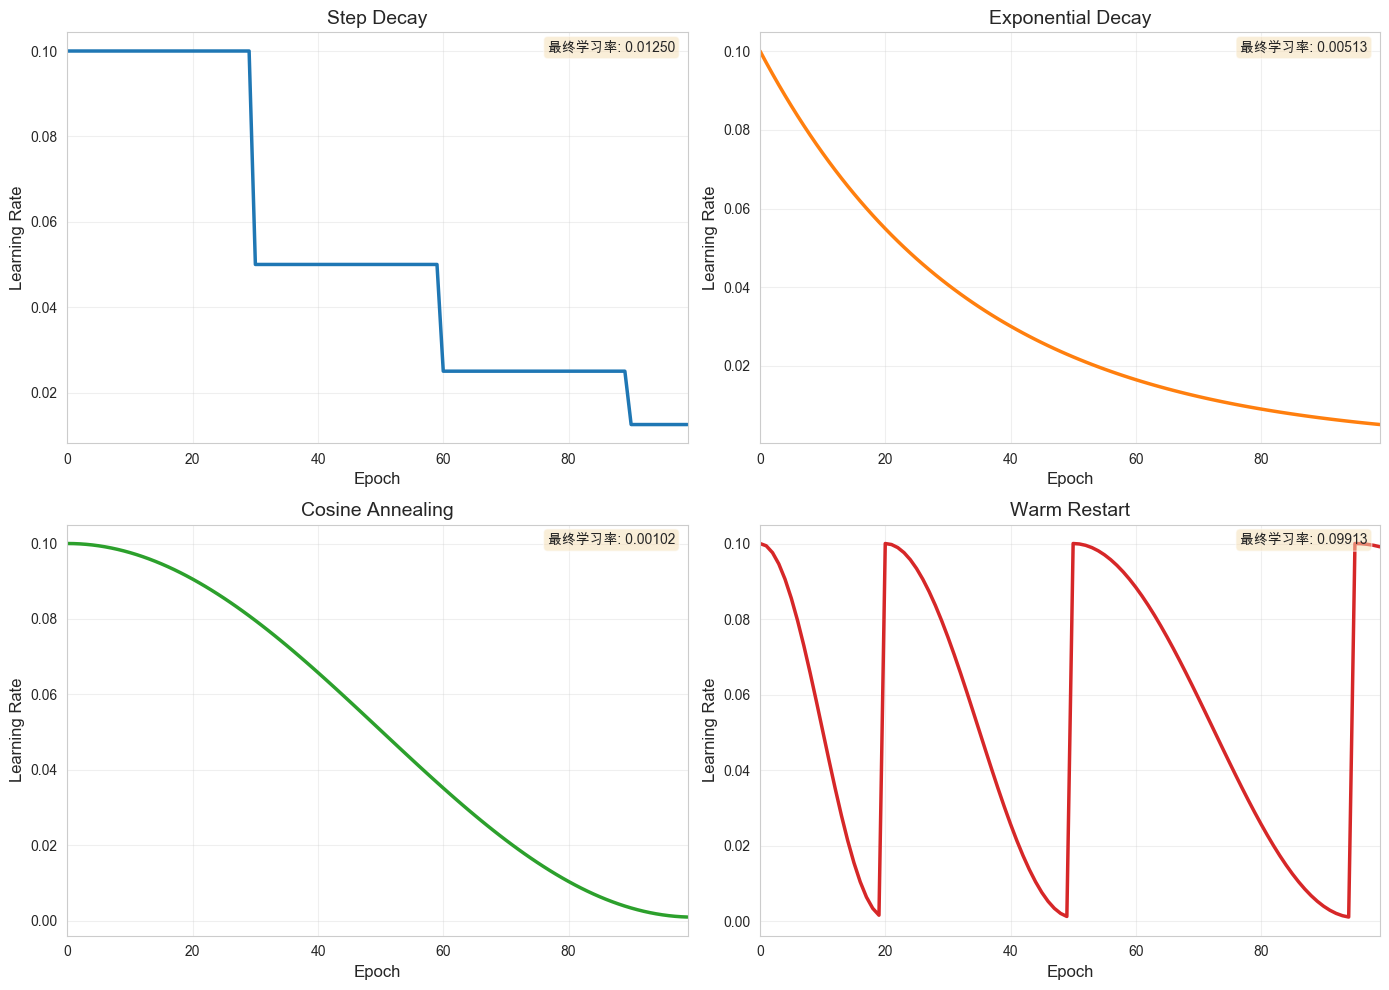


  学习率调度策略对比总结

Step Decay:
  初始: 0.10000 | 最终: 0.01250
  范围: [0.01250, 0.10000]
  特点: 阶梯式下降，适合明确知道何时降低学习率

Exponential Decay:
  初始: 0.10000 | 最终: 0.00513
  范围: [0.00513, 0.10000]
  特点: 平滑连续下降，适合长期训练

Cosine Annealing:
  初始: 0.10000 | 最终: 0.00102
  范围: [0.00102, 0.10000]
  特点: 余弦平滑下降，收敛更稳定

Warm Restart:
  初始: 0.10000 | 最终: 0.09913
  范围: [0.00112, 0.10000]
  特点: 周期性重启，帮助跳出局部最优


In [5]:
def visualize_lr_schedules(n_epochs=100):
    """
    可视化对比不同学习率调度策略
    
    参数:
        n_epochs: 训练的总epoch数
    """
    # 创建不同的调度器
    schedulers = {
        'Step Decay': StepDecayScheduler(initial_lr=0.1, decay_rate=0.5, decay_steps=30),
        'Exponential Decay': ExponentialDecayScheduler(initial_lr=0.1, decay_rate=0.03),
        'Cosine Annealing': CosineAnnealingScheduler(initial_lr=0.1, min_lr=0.001, T_max=n_epochs),
        'Warm Restart': WarmRestartScheduler(initial_lr=0.1, min_lr=0.001, T_0=20, T_mult=1.5)
    }
    
    # 模拟训练过程，记录学习率
    histories = {}
    for name, scheduler in schedulers.items():
        lr_history = []
        for epoch in range(n_epochs):
            lr = scheduler.update()
            lr_history.append(lr)
        histories[name] = lr_history
    
    # 绘制对比图
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, (name, history) in enumerate(histories.items()):
        ax = axes[idx]
        ax.plot(history, linewidth=2.5, color=sns.color_palette()[idx])
        ax.set_title(f'{name}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel('Learning Rate', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, n_epochs-1)
        
        # 添加关键信息
        final_lr = history[-1]
        ax.text(0.98, 0.98, f'最终学习率: {final_lr:.5f}', 
                transform=ax.transAxes, ha='right', va='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                fontsize=10)
    
    plt.tight_layout()
    plt.savefig('lr_schedules_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 对比总结
    print("\n" + "="*60)
    print("  学习率调度策略对比总结")
    print("="*60)
    for name, history in histories.items():
        initial = history[0]
        final = history[-1]
        min_lr = min(history)
        max_lr = max(history)
        print(f"\n{name}:")
        print(f"  初始: {initial:.5f} | 最终: {final:.5f}")
        print(f"  范围: [{min_lr:.5f}, {max_lr:.5f}]")
        print(f"  特点: ", end="")
        if name == 'Step Decay':
            print("阶梯式下降，适合明确知道何时降低学习率")
        elif name == 'Exponential Decay':
            print("平滑连续下降，适合长期训练")
        elif name == 'Cosine Annealing':
            print("余弦平滑下降，收敛更稳定")
        elif name == 'Warm Restart':
            print("周期性重启，帮助跳出局部最优")
    print("="*60)

# 运行可视化
visualize_lr_schedules(n_epochs=100)

---

## 2️⃣ 梯度裁剪（Gradient Clipping）

### 🔥 梯度爆炸问题

**什么是梯度爆炸？**

在深层网络中，梯度在反向传播时可能会指数级增长：

$$
\frac{\partial L}{\partial W^{(1)}} = \frac{\partial L}{\partial W^{(L)}} \times \prod_{l=2}^{L} \frac{\partial W^{(l)}}{\partial W^{(l-1)}}
$$

**符号说明：**
- $\frac{\partial L}{\partial W}$: L 对 W 的偏导数（读作 "partial L partial W"）
- $\prod$: 连乘符号（读作 "product"，类似于求和 $\sum$ 但是做乘法）
- $W^{(l)}$: 第 l 层的权重矩阵

如果每层梯度都 >1，连乘会导致梯度爆炸！

**后果：**
- 参数更新过大
- loss变成NaN
- 训练崩溃

---

### ✂️ 梯度裁剪策略

#### 1. Norm Clipping（范数裁剪）⭐ 推荐

**原理：** 限制梯度向量的L2范数不超过阈值

$$
\mathbf{g} \leftarrow \begin{cases}
\mathbf{g} & \text{if } \|\mathbf{g}\| \leq \theta \\
\frac{\theta}{\|\mathbf{g}\|} \mathbf{g} & \text{if } \|\mathbf{g}\| > \theta
\end{cases}
$$

**符号说明：**
- $\mathbf{g}$（粗体 g）: 梯度向量
- $\|\mathbf{g}\|$（读作 "norm of g"）: 梯度的 L2 范数，即 $\sqrt{\sum_i g_i^2}$
- $\theta$（theta）: 裁剪阈值（threshold），如 1.0 或 5.0
- $\leftarrow$: 赋值符号，表示"更新为"

**公式解读：**
- 如果梯度范数 $\leq \theta$：不裁剪，保持原样
- 如果梯度范数 $> \theta$：将梯度缩放到范数恰好等于 $\theta$

**优点：**
- 保持梯度方向不变
- 只缩放幅度

#### 2. Value Clipping（值裁剪）

**原理：** 限制梯度的每个元素在 $[-\theta, \theta]$

$$
g_i \leftarrow \text{clip}(g_i, -\theta, \theta)
$$

**符号说明：**
- $g_i$: 梯度向量的第 i 个元素
- $\text{clip}(x, a, b)$: 将 x 限制在 $[a, b]$ 范围内

**缺点：**
- 改变梯度方向
- 不如Norm Clipping常用

---

### 💻 从零实现：梯度裁剪

In [6]:
def clip_gradient_norm(gradients: List[np.ndarray], max_norm: float = 1.0) -> Tuple[List[np.ndarray], float]:
    """
    梯度范数裁剪（推荐方法）
    
    公式: g ← (max_norm / ||g||) × g  if ||g|| > max_norm
    
    参数:
        gradients: 梯度列表 [dW1, db1, dW2, db2, ...]
        max_norm: 最大梯度范数（阈值 θ）
    
    返回:
        裁剪后的梯度, 原始梯度范数
    """
    # ===== 步骤1: 计算所有梯度的L2范数 =====
    # ||g|| = sqrt(sum(g_i^2)) for all parameters
    # 
    # 将所有参数的梯度平方累加，最后开方
    total_norm = 0.0
    for grad in gradients:
        total_norm += np.sum(grad ** 2)  # 累加每个参数的梯度平方和
    total_norm = np.sqrt(total_norm)  # 开平方得到L2范数
    
    # ===== 步骤2: 计算裁剪系数 =====
    # clip_coef = max_norm / ||g||
    # 
    # 如果 clip_coef < 1，说明梯度太大，需要缩放
    # 如果 clip_coef >= 1，说明梯度正常，不需要裁剪
    clip_coef = max_norm / (total_norm + 1e-6)  # 加小数防止除零
    
    # ===== 步骤3: 裁剪梯度 =====
    if clip_coef < 1:  # 需要裁剪
        # 所有梯度乘以相同的缩放系数，保持方向不变
        clipped_gradients = [grad * clip_coef for grad in gradients]
        return clipped_gradients, total_norm
    else:  # 不需要裁剪，返回原始梯度
        return gradients, total_norm


def clip_gradient_value(gradients: List[np.ndarray], clip_value: float = 1.0) -> List[np.ndarray]:
    """
    梯度值裁剪（逐元素裁剪）
    
    公式: g_i ← clip(g_i, -clip_value, clip_value)
    
    参数:
        gradients: 梯度列表
        clip_value: 裁剪阈值 θ
    
    返回:
        裁剪后的梯度
    """
    # 将每个梯度的元素限制在 [-clip_value, clip_value]
    # 注意：这会改变梯度的方向！
    clipped_gradients = [np.clip(grad, -clip_value, clip_value) for grad in gradients]
    return clipped_gradients


# ===== 演示梯度爆炸 vs 梯度裁剪 =====
def demonstrate_gradient_clipping():
    """
    演示梯度裁剪的效果
    """
    print("="*60)
    print("  梯度裁剪演示")
    print("="*60)
    
    # 模拟一个梯度爆炸的场景
    # 假设我们有3个参数矩阵的梯度，都非常大！
    dW1 = np.random.randn(10, 20) * 100  # 梯度很大！
    dW2 = np.random.randn(20, 30) * 100
    dW3 = np.random.randn(30, 10) * 100
    
    gradients = [dW1, dW2, dW3]
    
    # 计算原始梯度范数
    original_norm = 0.0
    for grad in gradients:
        original_norm += np.sum(grad ** 2)
    original_norm = np.sqrt(original_norm)
    
    print(f"\n原始梯度范数: {original_norm:.2f}")
    print(f"  dW1 范数: {np.linalg.norm(dW1):.2f}")
    print(f"  dW2 范数: {np.linalg.norm(dW2):.2f}")
    print(f"  dW3 范数: {np.linalg.norm(dW3):.2f}")
    
    # 使用梯度范数裁剪
    max_norm = 10.0
    clipped_grads, _ = clip_gradient_norm(gradients, max_norm=max_norm)
    
    clipped_norm = 0.0
    for grad in clipped_grads:
        clipped_norm += np.sum(grad ** 2)
    clipped_norm = np.sqrt(clipped_norm)
    
    print(f"\n裁剪后梯度范数: {clipped_norm:.2f} (阈值 θ: {max_norm})")
    print(f"  dW1 范数: {np.linalg.norm(clipped_grads[0]):.2f}")
    print(f"  dW2 范数: {np.linalg.norm(clipped_grads[1]):.2f}")
    print(f"  dW3 范数: {np.linalg.norm(clipped_grads[2]):.2f}")
    
    print(f"\n缩放系数: {max_norm / original_norm:.4f}")
    print(f"✅ 梯度范数从 {original_norm:.2f} 降低到 {clipped_norm:.2f}")
    print("="*60)

demonstrate_gradient_clipping()

  梯度裁剪演示

原始梯度范数: 3240.74
  dW1 范数: 1314.61
  dW2 范数: 2450.15
  dW3 范数: 1664.62

裁剪后梯度范数: 10.00 (阈值 θ: 10.0)
  dW1 范数: 4.06
  dW2 范数: 7.56
  dW3 范数: 5.14

缩放系数: 0.0031
✅ 梯度范数从 3240.74 降低到 10.00


---

## 3️⃣ 梯度累积（Gradient Accumulation）

### 💡 为什么需要梯度累积？

**问题场景：**
- 想用 batch_size=128 训练，但 GPU 内存只够 batch_size=32
- 大批量训练更稳定，但硬件资源不足

**解决方案：梯度累积**

用多个小批量（如4个 batch_size=32）累积梯度，再更新一次参数，效果等同于 batch_size=128！

### 📐 原理

**正常训练（大批量）：**
$$
\theta \leftarrow \theta - \eta \nabla_\theta L(\theta; \mathcal{B}_{128})
$$

**符号说明：**
- $\theta$（theta）: 模型参数
- $\eta$（eta）: 学习率
- $\nabla_\theta L$（nabla theta L）: 损失函数对参数的梯度
- $\mathcal{B}_{128}$: 大小为128的批次

**梯度累积（模拟大批量）：**
$$
\begin{aligned}
g_{accum} &= \sum_{i=1}^{4} \nabla_\theta L(\theta; \mathcal{B}_{32}^{(i)}) \\
\theta &\leftarrow \theta - \eta \cdot \frac{g_{accum}}{4}
\end{aligned}
$$

**符号说明：**
- $\sum_{i=1}^{4}$: 对 4 个小批次求和
- $\mathcal{B}_{32}^{(i)}$: 第 i 个大小为32的小批次
- $g_{accum}$: 累积的梯度
- $\frac{g_{accum}}{4}$: 对累积梯度取平均

**关键：** 累积4个小批量的梯度，然后除以4（平均），再更新参数

### 🔍 为什么要除以累积步数？

假设我们用 batch_size=128 计算梯度，得到的是128个样本梯度的平均值。

如果改用4个 batch_size=32 的批次累积：
- 每个小批次计算的是32个样本的平均梯度
- 累积4个这样的梯度后，总共涉及 32×4=128 个样本
- 但累积的是4个"平均值"，所以要再除以4，才等价于128个样本的平均值

---

### 💻 从零实现：梯度累积

In [7]:
class GradientAccumulator:
    """
    梯度累积器
    
    原理：用多个小批量累积梯度，模拟大批量训练
    公式：g_accum = Σ g_i / n_accumulation_steps
    
    使用示例:
    --------
    accumulator = GradientAccumulator(accumulation_steps=4)
    
    for batch_idx, (X_batch, y_batch) in enumerate(data_loader):
        # 1. 前向传播 + 反向传播，计算梯度
        gradients = compute_gradients(X_batch, y_batch)
        
        # 2. 累积梯度
        accumulator.accumulate(gradients)
        
        # 3. 检查是否该更新参数
        if accumulator.should_update():
            # 获取平均后的梯度
            avg_gradients = accumulator.get_averaged_gradients()
            # 更新参数
            update_parameters(avg_gradients)
            # 重置累积器
            accumulator.reset()
    """
    
    def __init__(self, accumulation_steps: int = 4):
        """
        参数:
        -----
        accumulation_steps : int
            累积步数（多少个小批量累积后更新一次）
            
            示例：
            - accumulation_steps=4, batch_size=32
            - 等效于 batch_size=128
        """
        self.accumulation_steps = accumulation_steps
        self.step_count = 0  # 当前已累积的步数
        self.accumulated_gradients = None  # 累积的梯度
    
    def accumulate(self, gradients: List[np.ndarray]) -> None:
        """
        累积梯度
        
        参数:
        -----
        gradients : List[np.ndarray]
            当前批次的梯度列表 [dW1, db1, dW2, db2, ...]
        """
        if self.accumulated_gradients is None:
            # 第一个批次：直接复制梯度
            # 使用 copy() 避免修改原始梯度
            self.accumulated_gradients = [grad.copy() for grad in gradients]
        else:
            # 后续批次：累加梯度
            for i, grad in enumerate(gradients):
                self.accumulated_gradients[i] += grad
        
        # 增加步数计数
        self.step_count += 1
    
    def should_update(self) -> bool:
        """
        判断是否该更新参数
        
        返回:
        -----
        bool
            当累积步数达到 accumulation_steps 时返回 True
        """
        return self.step_count >= self.accumulation_steps
    
    def get_averaged_gradients(self) -> List[np.ndarray]:
        """
        获取平均后的梯度
        
        返回:
        -----
        List[np.ndarray]
            累积梯度除以累积步数，得到平均梯度
        """
        if self.accumulated_gradients is None:
            raise ValueError("没有累积的梯度！请先调用 accumulate()")
        
        # 累积梯度 / 累积步数 = 平均梯度
        averaged_gradients = [
            grad / self.accumulation_steps 
            for grad in self.accumulated_gradients
        ]
        return averaged_gradients
    
    def reset(self) -> None:
        """重置累积器，准备下一轮累积"""
        self.accumulated_gradients = None
        self.step_count = 0


# ===== 演示梯度累积 =====
def demonstrate_gradient_accumulation():
    """
    演示梯度累积的效果
    
    对比：
    1. 大批量一次性训练 (batch_size=128)
    2. 小批量累积训练 (4 × batch_size=32)
    """
    print("="*70)
    print("  梯度累积演示")
    print("="*70)
    
    # 模拟数据
    np.random.seed(42)
    n_samples = 128
    n_features = 10
    X = np.random.randn(n_samples, n_features)
    
    # 模拟简单的梯度计算（实际中是反向传播）
    def compute_mock_gradient(X_batch):
        """模拟梯度计算：返回批次均值作为"梯度" """
        return [np.mean(X_batch, axis=0)]
    
    # ===== 方法1：大批量一次性计算 =====
    print("\n方法1：大批量一次性计算 (batch_size=128)")
    print("-"*50)
    large_batch_gradient = compute_mock_gradient(X)
    print(f"  梯度前3个元素: {large_batch_gradient[0][:3]}")
    
    # ===== 方法2：小批量累积 =====
    print("\n方法2：小批量累积 (4 × batch_size=32)")
    print("-"*50)
    
    accumulator = GradientAccumulator(accumulation_steps=4)
    batch_size = 32
    
    for i in range(4):
        # 取出小批量
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        X_batch = X[start_idx:end_idx]
        
        # 计算梯度
        gradients = compute_mock_gradient(X_batch)
        print(f"  批次 {i+1} 梯度前3元素: {gradients[0][:3]}")
        
        # 累积梯度
        accumulator.accumulate(gradients)
    
    # 获取平均梯度
    accumulated_gradient = accumulator.get_averaged_gradients()
    print(f"\n  累积平均梯度前3元素: {accumulated_gradient[0][:3]}")
    
    # ===== 对比结果 =====
    print("\n" + "="*70)
    print("  对比结果")
    print("="*70)
    
    difference = np.abs(large_batch_gradient[0] - accumulated_gradient[0])
    max_diff = np.max(difference)
    
    print(f"\n  大批量梯度:     {large_batch_gradient[0][:5]}")
    print(f"  累积平均梯度:   {accumulated_gradient[0][:5]}")
    print(f"  最大差异:       {max_diff:.10f}")
    
    if max_diff < 1e-10:
        print("\n  ✅ 两种方法得到的梯度完全相同！")
        print("     梯度累积成功模拟了大批量训练")
    else:
        print(f"\n  ⚠️  存在微小差异: {max_diff}")
    
    print("="*70)


# 运行演示
demonstrate_gradient_accumulation()

print("\n" + "="*70)
print("💡 梯度累积使用建议：")
print("="*70)
print("  1️⃣  内存不足时的首选方案")
print("  2️⃣  accumulation_steps 通常设为 2、4、8")
print("  3️⃣  等效 batch_size = 实际 batch_size × accumulation_steps")
print("  4️⃣  注意：累积后要除以步数取平均！")
print("  5️⃣  学习率可能需要相应调整")
print("="*70)

  梯度累积演示

方法1：大批量一次性计算 (batch_size=128)
--------------------------------------------------
  梯度前3个元素: [ 0.02292646 -0.02943748  0.00888137]

方法2：小批量累积 (4 × batch_size=32)
--------------------------------------------------
  批次 1 梯度前3元素: [-0.11715067  0.12137684  0.11460224]
  批次 2 梯度前3元素: [ 0.03074304  0.12032159 -0.18972399]
  批次 3 梯度前3元素: [ 0.04255669 -0.2033879  -0.07094402]
  批次 4 梯度前3元素: [ 0.13555676 -0.15606045  0.18159125]

  累积平均梯度前3元素: [ 0.02292646 -0.02943748  0.00888137]

  对比结果

  大批量梯度:     [ 0.02292646 -0.02943748  0.00888137  0.0761187   0.11861302]
  累积平均梯度:   [ 0.02292646 -0.02943748  0.00888137  0.0761187   0.11861302]
  最大差异:       0.0000000000

  ✅ 两种方法得到的梯度完全相同！
     梯度累积成功模拟了大批量训练

💡 梯度累积使用建议：
  1️⃣  内存不足时的首选方案
  2️⃣  accumulation_steps 通常设为 2、4、8
  3️⃣  等效 batch_size = 实际 batch_size × accumulation_steps
  4️⃣  注意：累积后要除以步数取平均！
  5️⃣  学习率可能需要相应调整


---

## 4️⃣ 训练诊断（Training Diagnostics）

### 🩺 如何判断训练出了问题？

训练深度网络就像看病，需要：
1. **观察症状**：Loss曲线、准确率
2. **诊断病因**：过拟合？欠拟合？梯度问题？
3. **对症下药**：调整超参数、改模型结构

### 📊 核心诊断工具

#### 1. 学习曲线分析

**好的学习曲线：**
- 训练loss和验证loss都下降
- 两者差距不大

**过拟合：**
- 训练loss持续下降
- 验证loss上升或不再下降
- **解决方案：** 正则化、Dropout、更多数据

**欠拟合：**
- 训练loss和验证loss都很高
- 两者都不再下降
- **解决方案：** 增加模型容量、训练更久、降低正则化

#### 2. 决策树诊断

```
Loss是NaN/Inf？
├─ YES → 梯度爆炸：降低学习率 + 梯度裁剪
└─ NO  → 继续检查

训练Loss很高且不降？
├─ YES → 欠拟合：增加模型容量/训练更久
└─ NO  → 继续检查

训练Loss低，验证Loss高？
├─ YES → 过拟合：增加正则化/Dropout
└─ NO  → 训练状态良好！
```

---

### 💻 从零实现：训练诊断工具

In [8]:
def diagnose_training(train_loss_history: List[float], val_loss_history: List[float], 
                       train_acc_history: List[float] = None, val_acc_history: List[float] = None):
    """
    训练诊断决策树
    
    根据训练和验证 loss/acc 的表现，诊断训练问题并给出建议
    
    参数:
    -----
    train_loss_history : List[float]
        训练集 loss 历史记录
    val_loss_history : List[float]
        验证集 loss 历史记录
    train_acc_history : List[float], optional
        训练集准确率历史（可选）
    val_acc_history : List[float], optional
        验证集准确率历史（可选）
    """
    print("\n" + "="*70)
    print("  🩺 训练诊断报告")
    print("="*70)
    
    # ===== 基本统计 =====
    final_train_loss = train_loss_history[-1]
    final_val_loss = val_loss_history[-1]
    loss_gap = abs(final_val_loss - final_train_loss)
    
    # 计算 loss 趋势（最近10个epoch的平均变化）
    recent_epochs = min(10, len(train_loss_history) // 2)
    train_trend = np.mean(np.diff(train_loss_history[-recent_epochs:]))
    val_trend = np.mean(np.diff(val_loss_history[-recent_epochs:]))
    
    print(f"\n📊 数据概览:")
    print(f"  训练集Loss: {final_train_loss:.4f}")
    print(f"  验证集Loss: {final_val_loss:.4f}")
    print(f"  Loss差距: {loss_gap:.4f}")
    
    if train_acc_history and val_acc_history:
        final_train_acc = train_acc_history[-1]
        final_val_acc = val_acc_history[-1]
        print(f"  训练集准确率: {final_train_acc:.2%}")
        print(f"  验证集准确率: {final_val_acc:.2%}")
    
    print(f"\n📈 趋势分析（最近{recent_epochs}个epoch）:")
    print(f"  训练Loss趋势: {train_trend:+.5f} {'📉 下降' if train_trend < 0 else '📈 上升'}")
    print(f"  验证Loss趋势: {val_trend:+.5f} {'📉 下降' if val_trend < 0 else '📈 上升'}")
    
    # ===== 决策树诊断 =====
    print(f"\n🔍 诊断结果:")
    
    # 1. 检查梯度消失/爆炸
    if np.isnan(final_train_loss) or np.isinf(final_train_loss):
        print("\n💥 **训练崩溃（梯度爆炸）！**")
        print("  症状: Loss变成NaN或Inf")
        print("  💊 建议:")
        print("     1. 降低学习率")
        print("     2. 使用梯度裁剪")
        print("     3. 检查权重初始化")
        print("     4. 使用Batch Normalization")
    
    # 2. 检查严重过拟合
    elif loss_gap > 0.5 and final_train_loss < 0.5:
        print("\n❌ **严重过拟合！**")
        print("  症状: 训练loss很低，但验证loss很高")
        print("  💊 建议:")
        print("     1. 增加正则化（L2、Dropout）")
        print("     2. 使用数据增强")
        print("     3. 减小模型容量")
        print("     4. 提前停止训练")
        print("     5. 收集更多训练数据")
    
    # 3. 检查轻度过拟合
    elif loss_gap > 0.2 and val_trend > 0:
        print("\n⚠️  **轻度过拟合**")
        print("  症状: 验证loss开始上升，训练loss继续下降")
        print("  💊 建议:")
        print("     1. 添加Dropout")
        print("     2. 增加L2正则化")
        print("     3. 考虑提前停止")
    
    # 4. 检查欠拟合
    elif final_train_loss > 1.0 and train_trend > -0.001:
        print("\n❌ **欠拟合！**")
        print("  症状: 训练loss和验证loss都很高，且不再下降")
        print("  💊 建议:")
        print("     1. 增加模型容量（更多层/神经元）")
        print("     2. 训练更多epoch")
        print("     3. 降低正则化强度")
        print("     4. 使用更强的优化器（如Adam）")
        print("     5. 检查学习率是否过小")
    
    # 5. 训练停滞
    elif abs(train_trend) < 0.001 and final_train_loss > 0.5:
        print("\n⚠️  **训练停滞**")
        print("  症状: Loss不再下降，但还没收敛")
        print("  💊 建议:")
        print("     1. 降低学习率（使用学习率调度）")
        print("     2. 检查是否陷入局部最优")
        print("     3. 尝试Warm Restart")
        print("     4. 增加batch size")
    
    # 6. 训练正常
    else:
        print("\n✅ **训练状态良好！**")
        print("  训练loss和验证loss都在下降，且差距合理")
        if train_trend < -0.001:
            print("  建议: 继续训练，可能还能进一步优化")
        else:
            print("  建议: 已接近收敛，可以考虑停止训练")
    
    print("\n" + "="*70)


# ===== 示例：诊断不同的训练情况 =====
print("示例1: 过拟合情况")
train_loss_overfitting = [1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.05]
val_loss_overfitting = [1.0, 0.85, 0.75, 0.7, 0.75, 0.85, 0.9]
diagnose_training(train_loss_overfitting, val_loss_overfitting)

print("\n" + "-"*70)
print("\n示例2: 欠拟合情况")
train_loss_underfitting = [2.0, 1.8, 1.7, 1.65, 1.6, 1.59, 1.58]
val_loss_underfitting = [2.1, 1.9, 1.8, 1.75, 1.7, 1.69, 1.68]
diagnose_training(train_loss_underfitting, val_loss_underfitting)

print("\n" + "-"*70)
print("\n示例3: 训练正常")
train_loss_good = [1.5, 1.2, 0.9, 0.7, 0.5, 0.4, 0.3]
val_loss_good = [1.5, 1.25, 0.95, 0.75, 0.58, 0.5, 0.45]
diagnose_training(train_loss_good, val_loss_good)

示例1: 过拟合情况

  🩺 训练诊断报告

📊 数据概览:
  训练集Loss: 0.0500
  验证集Loss: 0.9000
  Loss差距: 0.8500

📈 趋势分析（最近3个epoch）:
  训练Loss趋势: -0.07500 📉 下降
  验证Loss趋势: +0.07500 📈 上升

🔍 诊断结果:

❌ **严重过拟合！**
  症状: 训练loss很低，但验证loss很高
  💊 建议:
     1. 增加正则化（L2、Dropout）
     2. 使用数据增强
     3. 减小模型容量
     4. 提前停止训练
     5. 收集更多训练数据


----------------------------------------------------------------------

示例2: 欠拟合情况

  🩺 训练诊断报告

📊 数据概览:
  训练集Loss: 1.5800
  验证集Loss: 1.6800
  Loss差距: 0.1000

📈 趋势分析（最近3个epoch）:
  训练Loss趋势: -0.01000 📉 下降
  验证Loss趋势: -0.01000 📉 下降

🔍 诊断结果:

✅ **训练状态良好！**
  训练loss和验证loss都在下降，且差距合理
  建议: 继续训练，可能还能进一步优化


----------------------------------------------------------------------

示例3: 训练正常

  🩺 训练诊断报告

📊 数据概览:
  训练集Loss: 0.3000
  验证集Loss: 0.4500
  Loss差距: 0.1500

📈 趋势分析（最近3个epoch）:
  训练Loss趋势: -0.10000 📉 下降
  验证Loss趋势: -0.06500 📉 下降

🔍 诊断结果:

✅ **训练状态良好！**
  训练loss和验证loss都在下降，且差距合理
  建议: 继续训练，可能还能进一步优化



---

## 5️⃣ 早停（Early Stopping）

### 🛑 什么是早停？

**问题**：训练太久会导致过拟合，但不知道什么时候该停

**解决方案**：监控验证集性能，当不再提升时自动停止训练

### 📐 原理

**核心思想**：
1. 每个 epoch 后评估验证集性能
2. 如果验证性能提升，保存模型并重置耐心计数器
3. 如果验证性能不提升，增加耐心计数器
4. 当耐心计数器超过阈值（patience），停止训练

**关键参数：**
- **patience**: 容忍多少个 epoch 没有提升（常用值：10-20）
- **min_delta**: 最小改进量，小于此值视为没有改进
- **mode**: `'min'`（监控loss）或 `'max'`（监控accuracy）

### 🔄 早停流程图

```
训练开始
    ↓
[训练一个epoch]
    ↓
评估验证集性能
    ↓
性能有提升？ ─── YES ──→ 保存模型，重置计数器 ──→ 继续训练
    │
   NO
    ↓
计数器 + 1
    ↓
计数器 ≥ patience？ ─── YES ──→ 停止训练，返回最佳模型
    │
   NO
    ↓
继续训练
```

---

### 💻 从零实现：早停

In [ ]:
class EarlyStopping:
    """
    早停（Early Stopping）实现
    
    监控验证集性能，当连续 patience 个 epoch 没有提升时停止训练
    
    使用示例:
    --------
    early_stopping = EarlyStopping(patience=10, min_delta=0.001)
    
    for epoch in range(max_epochs):
        train_loss = train_one_epoch(...)
        val_loss = validate(...)
        
        # 检查是否应该停止
        if early_stopping.step(val_loss, model):
            print(f"Early stopping at epoch {epoch}")
            break
    
    # 加载最佳模型
    model = early_stopping.load_best_model()
    """
    
    def __init__(self, patience: int = 10, min_delta: float = 0.0, 
                 mode: str = 'min', verbose: bool = True):
        """
        参数:
        -----
        patience : int
            容忍的 epoch 数（连续 patience 个 epoch 没提升就停止）
        min_delta : float
            最小改进量（小于此值视为没有改进）
            例如：val_loss 从 0.5 降到 0.499，min_delta=0.002 则视为无改进
        mode : str
            'min'（监控 loss，越小越好）
            'max'（监控 accuracy，越大越好）
        verbose : bool
            是否打印信息
        """
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.verbose = verbose
        
        # 状态变量
        self.counter = 0  # 没有改进的 epoch 计数
        self.best_score = None  # 最佳验证性能
        self.best_model = None  # 最佳模型（权重的深拷贝）
        self.early_stop = False  # 是否应该停止训练
        self.val_score_history = []  # 验证性能历史
        
        # 根据 mode 设置比较函数
        if mode == 'min':
            # 监控 loss：新值 < 旧值 - delta 才算改进
            self.is_better = lambda new, best: new < best - min_delta
        elif mode == 'max':
            # 监控 accuracy：新值 > 旧值 + delta 才算改进
            self.is_better = lambda new, best: new > best + min_delta
        else:
            raise ValueError(f"mode must be 'min' or 'max', got {mode}")
    
    def step(self, val_score: float, model=None) -> bool:
        """
        检查是否应该早停
        
        参数:
        -----
        val_score : float
            当前 epoch 的验证性能（loss 或 accuracy）
        model : object, optional
            模型对象（如果提供则保存最佳模型权重）
        
        返回:
        -----
        bool
            是否应该停止训练
        """
        self.val_score_history.append(val_score)
        
        # 第一次评估：初始化最佳性能
        if self.best_score is None:
            self.best_score = val_score
            if model is not None:
                self._save_model(model)
            if self.verbose:
                print(f"  🎯 初始验证性能: {val_score:.4f}")
            return False
        
        # 检查是否有改进
        if self.is_better(val_score, self.best_score):
            # 有改进：更新最佳性能，重置计数器
            improvement = abs(val_score - self.best_score)
            self.best_score = val_score
            self.counter = 0
            
            if model is not None:
                self._save_model(model)
            
            if self.verbose:
                print(f"  ✅ 验证性能提升 {improvement:.4f} → 新最佳: {val_score:.4f}")
        else:
            # 没有改进：增加计数器
            self.counter += 1
            
            if self.verbose:
                print(f"  ⏳ 验证性能未提升（{self.counter}/{self.patience}） "
                      f"当前: {val_score:.4f} vs 最佳: {self.best_score:.4f}")
            
            # 检查是否应该停止
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"  🛑 早停触发！连续{self.patience}个epoch无改进")
                return True
        
        return False
    
    def _save_model(self, model):
        """保存模型权重的深拷贝"""
        import copy
        # 这里简单地保存整个模型的深拷贝
        # 在实际应用中，可能只保存权重字典
        self.best_model = copy.deepcopy(model)
    
    def load_best_model(self):
        """加载最佳模型"""
        if self.best_model is None:
            raise ValueError("没有保存的最佳模型")
        return self.best_model


# ===== 演示早停 =====
print("="*70)
print("  早停（Early Stopping）演示")
print("="*70)

# 场景1：正常早停（过拟合情况）
print("\n场景1：正常早停（模型开始过拟合）")
print("-"*70)

# 模拟验证 loss：先下降，然后开始上升（过拟合信号）
val_losses = [1.0, 0.8, 0.6, 0.5, 0.48, 0.47, 0.48, 0.50, 0.52, 0.53, 0.54, 0.55]

early_stopping = EarlyStopping(patience=3, min_delta=0.01, mode='min', verbose=True)

for epoch, val_loss in enumerate(val_losses):
    print(f"\nEpoch {epoch+1}:")
    if early_stopping.step(val_loss):
        print(f"\n  训练在 Epoch {epoch+1} 停止")
        print(f"  最佳验证 loss: {early_stopping.best_score:.4f} "
              f"(Epoch {epoch+1 - early_stopping.patience})")
        break

print("\n"*2 + "="*70)
print("场景2：训练完成（持续改进）")
print("-"*70)

# 模拟验证 loss：持续下降
val_losses_good = [1.0, 0.8, 0.6, 0.5, 0.4, 0.35, 0.32, 0.30, 0.28]

early_stopping2 = EarlyStopping(patience=3, min_delta=0.01, mode='min', verbose=True)

stopped = False
for epoch, val_loss in enumerate(val_losses_good):
    print(f"\nEpoch {epoch+1}:")
    if early_stopping2.step(val_loss):
        stopped = True
        break

if not stopped:
    print(f"\n  ✅ 训练正常完成（{len(val_losses_good)} epochs）")
    print(f"  最终验证 loss: {early_stopping2.best_score:.4f}")

print("\n" + "="*70)
print("💡 早停使用建议：")
print("="*70)
print("  1️⃣  patience 设置：通常 10-20 个 epoch")
print("  2️⃣  min_delta：根据 loss 量级设置（如 loss~1.0，设 0.001）")
print("  3️⃣  保存最佳模型：避免返回过拟合的模型")
print("  4️⃣  结合学习率调度：在学习率降低前给足够耐心")
print("="*70)

---

## 📝 综合总结

### 🎯 核心技巧速查表

| 技巧 | 问题 | 解决方案 | 何时使用 |
|------|------|----------|----------|
| **学习率调度** | 学习率固定导致收敛慢或震荡 | Step/Exponential/Cosine/Warm Restart | 几乎所有训练任务 |
| **梯度裁剪** | 梯度爆炸，loss变NaN | Norm Clipping | RNN、深层网络 |
| **梯度累积** | 内存不足，无法用大批量 | 累积多个小批量梯度 | GPU内存受限时 |
| **训练诊断** | 不知道训练哪里出问题 | 学习曲线分析、决策树 | 调试训练问题 |
| **早停** | 不知道何时停止训练 | 监控验证集性能 | 防止过拟合 |

---

### 🚀 实战建议

#### 1️⃣ 初始化训练流程（推荐配置）

```python
# 学习率调度（优先选择）
scheduler = CosineAnnealingScheduler(initial_lr=0.001, min_lr=1e-6, T_max=100)
# 或者
scheduler = WarmRestartScheduler(initial_lr=0.001, T_0=20, T_mult=2)

# 梯度裁剪（如果训练不稳定）
if gradient_exploding:
    gradients, _ = clip_gradient_norm(gradients, max_norm=1.0)

# 早停（防止过拟合）
early_stopping = EarlyStopping(patience=10, min_delta=0.001)

# 训练诊断（每N个epoch检查一次）
if epoch % 10 == 0:
    diagnose_training(train_loss_history, val_loss_history)
```

---

#### 2️⃣ 超参数调优顺序（重要性从高到低）

1. **学习率** ⭐⭐⭐⭐⭐（最重要！）
   - 先尝试：0.1, 0.01, 0.001, 0.0001
   - 使用学习率调度逐渐降低

2. **批量大小** ⭐⭐⭐⭐
   - 常见值：32, 64, 128, 256
   - 内存不够？用梯度累积

3. **网络结构** ⭐⭐⭐
   - 层数、神经元数
   - 根据欠拟合/过拟合调整

4. **正则化** ⭐⭐
   - L2正则化系数、Dropout率
   - 先训练基础模型，再加正则化

5. **优化器** ⭐
   - Adam（万能选择）
   - SGD+Momentum（精调用）

---

#### 3️⃣ 训练问题快速诊断

```
Loss是NaN/Inf？
├─ YES → 降低学习率 + 梯度裁剪 + 检查初始化
└─ NO  → 继续

训练Loss高且不降？
├─ YES → 欠拟合：增加模型容量/训练更久/降低正则化
└─ NO  → 继续

训练Loss低，验证Loss高？
├─ YES → 过拟合：增加正则化/Dropout/数据增强/早停
└─ NO  → 训练状态良好！
```

---

### 💡 最佳实践

1. **永远使用学习率调度**
   - 推荐：Cosine Annealing 或 Warm Restart
   - 至少使用 Step Decay

2. **监控梯度范数**
   - 如果梯度范数突然变大（>10），使用梯度裁剪

3. **使用早停**
   - patience 设为 10-20
   - 保存最佳模型

4. **定期诊断**
   - 每10个epoch检查学习曲线
   - 根据诊断结果及时调整

5. **实验记录**
   - 记录每次实验的超参数和结果
   - 对比不同配置的效果

---

## 🏋️ 练习题

### ⭐⭐ 练习1：实现完整训练循环

**任务：** 实现一个包含所有技巧的训练循环。

**要求：**
- 使用 Cosine Annealing 学习率调度
- 使用梯度裁剪（max_norm=1.0）
- 使用早停（patience=10）
- 每10个epoch进行训练诊断

---

### ⭐⭐⭐ 练习2：对比不同学习率调度策略

**任务：** 在MNIST数据集上训练同一个网络，对比4种学习率调度策略的效果。

**要求：**
1. 使用相同的网络架构
2. 对比：Fixed LR、Step Decay、Cosine Annealing、Warm Restart
3. 绘制loss曲线对比图
4. 分析哪种策略收敛最快、最终效果最好

---

### ⭐⭐⭐⭐ 练习3：实现完整的训练监控系统

**任务：** 实现一个训练监控类，集成本章所有技术。

**参考框架：**
```python
class TrainingMonitor:
    def __init__(self, model, lr_scheduler, gradient_clip_max_norm=1.0):
        self.early_stopping = EarlyStopping(patience=10)
        self.lr_scheduler = lr_scheduler
        self.max_norm = gradient_clip_max_norm
    
    def train_epoch(self, X_train, y_train):
        # 训练一个epoch + 梯度裁剪
        pass
    
    def validate(self, X_val, y_val):
        # 验证 + 早停检查
        pass
    
    def diagnose(self):
        # 诊断训练状态
        pass
```

---

### ⭐⭐⭐⭐⭐ 练习4：超参数网格搜索

**任务：** 系统化地搜索最佳超参数组合。

**搜索空间：**
- 学习率：[0.1, 0.01, 0.001]
- 批量大小：[32, 64, 128]
- 学习率调度：[Step, Cosine]
- 正则化：[0.0, 0.01, 0.001]

---

## 🎓 学习检查点

完成本章后，你应该能够：

- [ ] **理解并实现** 4种学习率调度策略
- [ ] **掌握梯度裁剪** 的原理和两种方法
- [ ] **实现梯度累积** 来模拟大批量训练
- [ ] **使用训练诊断工具** 识别过拟合/欠拟合
- [ ] **使用早停** 防止过拟合
- [ ] **系统化调参** 而不是随机尝试

---

## 📚 扩展阅读

### 论文

1. **SGDR: Stochastic Gradient Descent with Warm Restarts**
   - Loshchilov & Hutter, 2017
   - Cosine Annealing with Warm Restarts的原始论文

2. **On the difficulty of training Recurrent Neural Networks**
   - Pascanu et al., 2013
   - 梯度裁剪的理论基础

3. **Cyclical Learning Rates for Training Neural Networks**
   - Smith, 2017
   - 循环学习率策略

### 实践资源

- **PyTorch学习率调度器**: `torch.optim.lr_scheduler`
- **TensorFlow Callbacks**: 训练监控和提前停止
- **Weights & Biases**: 实验追踪工具

---

**恭喜！你已经掌握了深度网络训练的核心技巧！🎉**

这些技术是深度学习工程师的必备工具，能够帮助你：
- ✅ 更快地训练模型
- ✅ 避免训练崩溃
- ✅ 系统化地解决训练问题
- ✅ 找到最佳超参数配置

**下一步：** 第10章将学习如何使用PyTorch和TensorFlow，将这些技术应用到生产级项目中！